Librerías

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

/opt/anaconda3/envs/Python38andR/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datos

Vamos a trabajar con los datos de precipitación mensual ponderada de Colombia

In [2]:
Lluvia=pd.read_excel('Lluvia.xlsx')
Lluvia=Lluvia.set_index('Fecha')
Lluvia=Lluvia.asfreq('MS')
Lluvia=Lluvia.rename(columns={'lluvia':'yprecip'})
Lluvia.head()

,yprecip
Fecha,
2009-01-01,3.758065
2009-02-01,4.235714
2009-03-01,4.764516
2009-04-01,5.400000
2009-05-01,4.438710


In [3]:
print(f'Numero de filas con valores faltantes: {Lluvia.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


Verificación de que la serie es regularmente espaciada

In [4]:
(Lluvia.index == pd.date_range(start=Lluvia.index.min(),
                             end=Lluvia.index.max(),
                             freq=Lluvia.index.freq)).all()

True

In [5]:
Lluvia.shape

(132, 1)

Vamos a establecer que los últimos 12 meses(periodos) sean usando para medir la capacida predictiva

Train dates : 2009-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=120)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


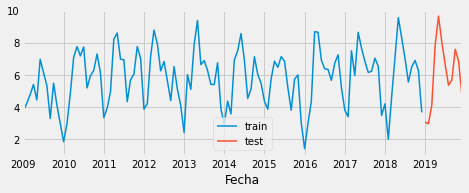

In [6]:
steps = 12
data_train = Lluvia[:-steps]
data_test  = Lluvia[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['yprecip'].plot(ax=ax, label='train')
data_test['yprecip'].plot(ax=ax, label='test')
ax.legend();

Vamos a crear un modelos a través de la clase ForecasterAutoreg, el cual es entrenado usando DecisionTreeRegressor

# Clase ForecasterAutoreg 

Permite crear una ventana de 3 retardos, es decir, se tomarán los últimos tres meses como predictores.Note que acá no se optimiza el número de nodos o particiones. Tenga en cuenta que se usarán las predicciones que se van obteniendo para predecir los pasos adelante que siguen.

In [8]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = DecisionTreeRegressor(),
                lags      = 3
             )

forecaster.fit(y=data_train['yprecip'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2023-05-29 13:31:33 
Last fit date: 2023-05-29 13:31:33 
Skforecast version: 0.8.0 
Python version: 3.8.8 
Forecaster id: None 

# Predicciones
 Una vez ajustado el modelo, se procede a hacer la prediccion de los 12 periodos en el fututo adelante, por supuesto usando las predicciones de forma recurrente.

In [9]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-01-01    3.925000
2019-02-01    4.938710
2019-03-01    5.400000
2019-04-01    5.400000
2019-05-01    6.746667
Freq: MS, Name: pred, dtype: float64

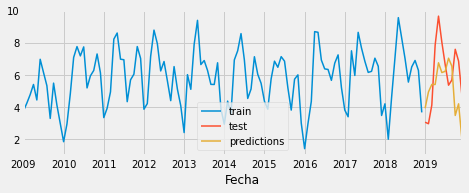

In [10]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['yprecip'].plot(ax=ax, label='train')
data_test['yprecip'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error de predicción en el conjunto de prueba

Acá se usará el conjunto de prueba para cuantificar la capacidad predictiva. Note que esta no es la verdadera capacidad predictiva, Por qué?

In [11]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['yprecip'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4.928583159814068


# Busqueda de los mejores hiperparámetros

La idea ahora es buscar la mejor combinación de retardos e hiperparámetros del modelo de árboles por medio de la función grid_search_forecaster. También hace random search y Bayesian search. Se hace Backtesting para validar la capacidad predictiva que tienen los modelos bajos los hiperparámetros propuestos. Se puede hacer validación cruzada o la tradicional entrenamiento y prueba. En este ejemplo se hace validación cruzada. Vale la pena recordar que validación cruzada se hace sobre el mismo conjunto de prueba, lo cual es diferente al caso de tener un conjunto de validación. Pero en el caso de tener conjunto de validación se debe tener en cuenta, por favor chequear https://skforecast.org/0.4.3/notebooks/prediction-intervals.html y debe incorporarse el conjunto de validación al de entrenamiento.

In [57]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = DecisionTreeRegressor(),
                lags      = 2 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [3,10, 20]

# Regressor's hyperparameters
param_grid = { 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['yprecip'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = True
               )

Number of models compared: 9.


lags grid:  33%|███▎      | 1/3 [00:00<00:00,  9.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 5
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=12)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=72)
    Validation: 2015-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=12)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=84)
    Validation: 2016-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=12)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=96)
    Validation: 2017-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=12)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=108)
    Validation: 2018-01-01 00:00:00 -- 2018-1


params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 5
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=12)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=72)
    Validation: 2015-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=12)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=84)
    Validation: 2016-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=12)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=96)
    Validation: 2017-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=12)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=108)
    Validation: 2018-01-01 00:00:00 -- 2018-1


params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 5
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=12)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=72)
    Validation: 2015-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=12)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2015-12-01 00:00:00  (n=84)
    Validation: 2016-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=12)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2016-12-01 00:00:00  (n=96)
    Validation: 2017-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=12)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=108)
    Validation: 2018-01-01 00:00:00 -- 2018-1


lags grid: 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]  

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3}
  Backtesting metric: 1.8235269801357565



In [58]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 3},1.823527,3
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 5},1.925009,5
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 10},2.228938,10
0,"[1, 2, 3]",{'max_depth': 3},2.505318,3
1,"[1, 2, 3]",{'max_depth': 5},2.743900,5
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 3},2.906727,3
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},4.457368,10
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},4.600448,5
2,"[1, 2, 3]",{'max_depth': 10},4.927817,10


# Modelo final

En la búsqueda hecha anteriormente se encontró la combinación óptima de los hiperparámetros por medio de validación cruzada secuencial para la predicción 2 pasos adelante por ejemplo.

In [59]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth=10)
                

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train['yprecip'])

Final_Forecaster=forecaster

In [60]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

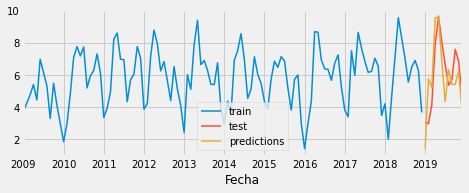

In [61]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['yprecip'].plot(ax=ax, label='train')
data_test['yprecip'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [62]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['yprecip'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
# note que gaora se ha reducido el error.

Test error (mse): 2.3466487458953096


# Backtesting

La idea del backtesting consiste en probar la capacidad predictiva de un modelo sobre el histórico de datos. Este es un caso especial de validación cruzada. Existen algunas variantes del backtesting.Para detalles ver https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html.
* Backtesting con reajuste e incremento del tamaño de entranamineto(origen fijo)
* Backtesting con reajuste  tamaño de entranamiento fijo(origen rodante)
* Backtesting sin reajuste

Atención: Independientemente de cuál se utilice, es importante no incluir datos de prueba(por ejemplo de hiperparámetros) en el proceso de búsqueda para evitar problemas de sobreajuste.

In [63]:
# Backtesting con reajuste
# ==============================================================================
steps = 2
n_backtesting = 12*2 # The last 2 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = Lluvia['yprecip'],
                                    initial_train_size = len(Lluvia) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True,
                                    show_progress      = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 108
Number of observations used for backtesting: 24
    Number of folds: 12
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=108)
    Validation: 2018-01-01 00:00:00 -- 2018-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2018-02-01 00:00:00  (n=110)
    Validation: 2018-03-01 00:00:00 -- 2018-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2018-04-01 00:00:00  (n=112)
    Validation: 2018-05-01 00:00:00 -- 2018-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2018-06-01 00:00:00  (n=114)
    Validation: 2018-07-01 00:00:00 -- 2018-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2018-08-01 00:00:00  (n=116)
    Validation: 2018-09-01 00:00:00 -- 2018-

100%|██████████| 12/12 [00:00<00:00, 192.81it/s]

Backtest error: 2.755583669333584


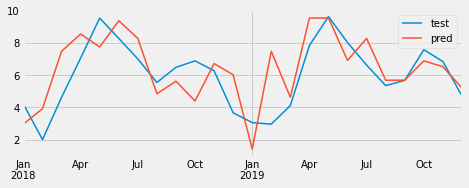

In [64]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
Lluvia.loc[predictions_backtest.index, 'yprecip'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

 # Importancia de los predictores

In [65]:
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.270922
1,lag_2,0.026094
2,lag_3,0.036891
3,lag_4,0.217388
4,lag_5,0.097368
5,lag_6,0.103970
6,lag_7,0.082150
7,lag_8,0.065375
8,lag_9,0.030416
9,lag_10,0.069425


Tarea: Leer Recursive autoregressive forecasting with custom predictors

# Direct multi-step forecasting(ForecasterAutoregDirect)

Las clases ForecasterAutoreg y ForecasterAutoregCustom siguen una estrategia de predicción recursiva en la que cada nueva predicción se basa en la anterior. Una alternativa es entrenar un modelo para cada uno de los pasos a predecir. Esta estrategia, comúnmente conocida como pronóstico directo de varios pasos(one-shot), es computacionalmente más costosa que la recursiva, ya que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, logra mejores resultados. Este tipo de modelos se pueden obtener con la clase ForecasterAutoregDirect y pueden incluir una o varias variables exógenas. 

In [66]:
regressor = DecisionTreeRegressor(max_depth=10)
                

forecaster = ForecasterAutoregDirect(
                regressor = regressor,
                lags      = 10,
                steps     =12,
                transformer_y = StandardScaler()
             )

forecaster

ForecasterAutoregDirect 
Regressor: DecisionTreeRegressor(max_depth=10) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 10 
Maximum steps predicted: 12 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2023-05-29 15:19:54 
Last fit date: None 
Skforecast version: 0.8.0 
Python version: 3.8.8 
Forecaster id: None 

In [67]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor = regressor,
                lags      = 10,
                steps     =12,
                transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [3,10, 20]

# Regressor's hyperparameters
param_grid = { 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['yprecip'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = True
               )

Number of models compared: 9.


params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


params grid:  67%|██████▋   | 2/3 [00:02<00:01,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 60
Number of observations used for backtesting: 60
    Number of folds: 30
    Number of steps per fold: 2
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2009-01-01 00:00:00 -- 2013-12-01 00:00:00  (n=60)
    Validation: 2014-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=2)
Fold: 1
    Training:   2009-01-01 00:00:00 -- 2014-02-01 00:00:00  (n=62)
    Validation: 2014-03-01 00:00:00 -- 2014-04-01 00:00:00  (n=2)
Fold: 2
    Training:   2009-01-01 00:00:00 -- 2014-04-01 00:00:00  (n=64)
    Validation: 2014-05-01 00:00:00 -- 2014-06-01 00:00:00  (n=2)
Fold: 3
    Training:   2009-01-01 00:00:00 -- 2014-06-01 00:00:00  (n=66)
    Validation: 2014-07-01 00:00:00 -- 2014-08-01 00:00:00  (n=2)
Fold: 4
    Training:   2009-01-01 00:00:00 -- 2014-08-01 00:00:00  (n=68)
    Validation: 2014-09-01 00:00:00 -- 2014-10-01 


lags grid: 100%|██████████| 3/3 [00:10<00:00,  3.65s/it]  

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3}
  Backtesting metric: 2.2751535546198243



In [68]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 3},2.275154,3
0,"[1, 2, 3]",{'max_depth': 3},2.275930,3
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 3},2.589106,3
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},2.684884,5
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 5},2.790683,5


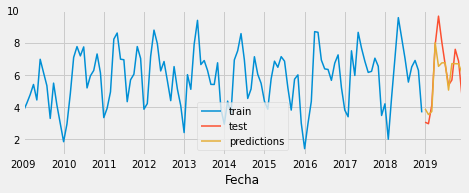

In [69]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['yprecip'].plot(ax=ax, label='train')
data_test['yprecip'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [70]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['yprecip'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 1.3735727650353953


Note que ahora el error es menor.

# Intervalos de Predicción

Una vez se tiene el modelo final, podemos ver como quedan los intervalos de predicción sobre el conjunto de prueba.


In [84]:
steps=12
Final_Forecaster.fit(y=data_train['yprecip'])

predictions = Final_Forecaster.predict_interval(
                    steps    = steps,
                    interval = [0.25, 99.75],
                    n_boot   = 500
              )

predictions.head(12)

,pred,lower_bound,upper_bound
2019-01-01,1.416129,1.350000,1.490824
2019-02-01,7.490323,7.424194,7.565018
2019-03-01,5.960000,5.898014,6.034695
2019-04-01,8.635484,8.569355,8.710179
2019-05-01,9.548387,8.635484,9.623082
2019-06-01,6.825806,6.759677,6.900502
2019-07-01,4.332258,4.266129,4.406953
2019-08-01,6.254767,6.188638,6.329462
2019-09-01,6.890323,6.824194,6.965018
2019-10-01,5.400000,5.333871,5.474695


Test error (mse): 3.5062225660329402


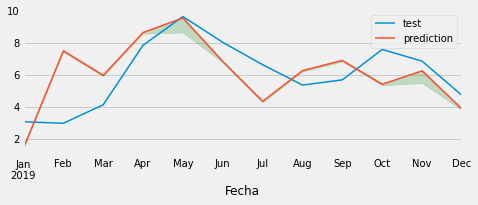

In [85]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['yprecip'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_test['yprecip'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'green',
    alpha = 0.2
)
ax.legend();